In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import final_project.config as c
import final_project.logic.Utils as u
from final_project.logic.Utils import Axis, EulerAngle as EA
from final_project.models.Trajectory import Trajectory

# "#1b7837", "#de77ae", "#762a83"
COLORS = ["gold", "cyan", "lightgreen", 'k']

In [2]:
# load data:
rel_pnp_cameras = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pnp_cameras.pkl"))
abs_pnp_cameras = pd.Series(u.convert_to_absolute_cameras(rel_pnp_cameras), index=rel_pnp_cameras.index, name=rel_pnp_cameras.name)
pnp_traj = Trajectory.from_absolute_cameras(abs_pnp_cameras)

rel_ba_cameras = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "ba_cameras.pkl"))
abs_ba_cameras = pd.Series(u.convert_to_absolute_cameras(rel_ba_cameras), index=rel_ba_cameras.index, name=rel_ba_cameras.name)
ba_traj = Trajectory.from_absolute_cameras(abs_ba_cameras)

rel_pg_cameras = pd.read_pickle(os.path.join(c.DATA_WRITE_PATH, "pg_cameras.pkl"))
abs_pg_cameras = pd.Series(u.convert_to_absolute_cameras(rel_pg_cameras), index=rel_pg_cameras.index, name=rel_pg_cameras.name)
pg_traj = Trajectory.from_absolute_cameras(abs_pg_cameras)

rel_gt_cameras = pd.Series(u.read_ground_truth_cameras(use_relative=True), index=rel_pnp_cameras.index, name="gt_cameras")
abs_gt_cameras = pd.Series(u.read_ground_truth_cameras(use_relative=False), index=rel_gt_cameras.index, name=rel_gt_cameras.name)
gt_traj = Trajectory.from_absolute_cameras(abs_gt_cameras)

In [3]:
def calculate_relative_distance(rel_cams):
    rel_traj = Trajectory.from_absolute_cameras(rel_cams)  # we use "from_absolute" on relative cameras to get the relative distance
    rel_distance = np.linalg.norm(rel_traj.coordinates, ord=2, axis=0)
    series_name = rel_cams.name.split("_")[0] + "_relative_distance"
    return pd.Series(rel_distance, index=rel_cams.index, name=series_name)

def find_axis_errors(est_cams, gt_cams, axis: Axis):
    assert len(est_cams) == len(gt_cams)
    if axis == Axis.ALL:
        est_distances = calculate_relative_distance(est_cams)
        gt_distances = calculate_relative_distance(gt_cams)
        s = est_distances - gt_distances
        s.name = "L2_errors"
        s.index = est_cams.index
        return s
    est_traj = Trajectory.from_absolute_cameras(est_cams)
    grtr_traj = Trajectory.from_absolute_cameras(gt_cams)
    diff = est_traj.coordinates - grtr_traj.coordinates
    s = pd.Series(diff[axis.value], name=axis.name+"_errors", index=est_cams.index)
    return s

def find_angle_errors(est_cams, gt_cams, angle: EA):
    n = len(est_cams)
    assert len(gt_cams) == n
    angle_errors = np.zeros(n)
    for i, idx in enumerate(est_cams.index):
        est_cam = est_cams[idx]
        gt_cam = gt_cams[idx]
        angles = est_cam.angles_between(gt_cam)
        angle_errors[i] = angles[angle.value]
    s = pd.Series(angle_errors, name=angle.name+"_errors", index=est_cams.index)
    return s

def running_sum(s: pd.Series, window: int) -> pd.Series:
    num_vals = len(s)
    assert window > 0, "window size must be positive"
    assert num_vals > window, "window size cannot be bigger than input series"
    res = s.rolling(window).sum().dropna()
    res.index = res.index - res.index.min()  # index should start at 0
    assert res.shape == (num_vals - window + 1,), f"{num_vals} - {window} +1 != {res.shape}"
    return res

Calculate error stats

In [4]:
window_sizes = [100, 300, 800]
gt_rel_dists = calculate_relative_distance(rel_gt_cameras)

pnp_means = np.zeros((2, 3))
for i in range(3):
    w = window_sizes[i]
    cumulated_distance = running_sum(gt_rel_dists, w)

    # L2 relative errors
    pnp_l2_errors = find_axis_errors(rel_pnp_cameras, rel_gt_cameras, Axis.ALL)
    pnp_relative_l2_errors = 100 * running_sum(pnp_l2_errors, w) / cumulated_distance
    pnp_means[0, i] = pnp_relative_l2_errors.mean()

    # Angle relative errors
    pnp_yaw_errors = find_angle_errors(rel_pnp_cameras, rel_gt_cameras, EA.YAW)
    pnp_yaw_relative_errors = running_sum(pnp_yaw_errors, w) / cumulated_distance
    pnp_pitch_errors = find_angle_errors(rel_pnp_cameras, rel_gt_cameras, EA.PITCH)
    pnp_pitch_relative_errors = running_sum(pnp_pitch_errors, w) / cumulated_distance
    pnp_roll_errors = find_angle_errors(rel_pnp_cameras, rel_gt_cameras, EA.ROLL)
    pnp_roll_relative_errors = running_sum(pnp_roll_errors, w) / cumulated_distance
    pnp_all_angles_relative_errors = pd.concat([pnp_yaw_relative_errors, pnp_pitch_relative_errors, pnp_roll_relative_errors], axis=0)
    pnp_means[1, i] = pnp_all_angles_relative_errors.mean()
pnp_mean_df = pd.DataFrame(pnp_means, columns=window_sizes, index=["L2", "Angle"])

ba_means = np.zeros((2, 3))
for i in range(3):
    w = window_sizes[i]
    cumulated_distance = running_sum(gt_rel_dists, w)

    # L2 relative errors
    ba_l2_errors = find_axis_errors(rel_ba_cameras, rel_gt_cameras, Axis.ALL)
    ba_relative_l2_errors = 100 * running_sum(ba_l2_errors, w) / cumulated_distance
    ba_means[0, i] = ba_relative_l2_errors.mean()

    # Angle relative errors
    ba_yaw_errors = find_angle_errors(rel_ba_cameras, rel_gt_cameras, EA.YAW)
    ba_yaw_relative_errors = running_sum(ba_yaw_errors, w) / cumulated_distance
    ba_pitch_errors = find_angle_errors(rel_ba_cameras, rel_gt_cameras, EA.PITCH)
    ba_pitch_relative_errors = running_sum(ba_pitch_errors, w) / cumulated_distance
    ba_roll_errors = find_angle_errors(rel_ba_cameras, rel_gt_cameras, EA.ROLL)
    ba_roll_relative_errors = running_sum(ba_roll_errors, w) / cumulated_distance
    ba_all_angles_relative_errors = pd.concat([ba_yaw_relative_errors, ba_pitch_relative_errors, ba_roll_relative_errors], axis=0)
    ba_means[1, i] = ba_all_angles_relative_errors.mean()
ba_mean_df = pd.DataFrame(ba_means, columns=window_sizes, index=["L2", "Angle"])

summary_df = pd.concat({"PnP": pnp_mean_df, "BA": ba_mean_df}, axis=0, names=["Stage", "ErrorType"])
summary_df.columns = pd.MultiIndex.from_product([["WindowSize"], summary_df.columns])
summary_df

WindowSize                    
                       100       300       800
Stage ErrorType                               
PnP   L2         -0.146645 -0.237219 -0.258361
      Angle      -0.003640 -0.003437 -0.003360
BA    L2         -0.138745 -0.137536 -0.155505
      Angle      -0.000109  0.000093  0.000013

##### Figure 12
relative errors for PnP

<Figure size 432x288 with 0 Axes>

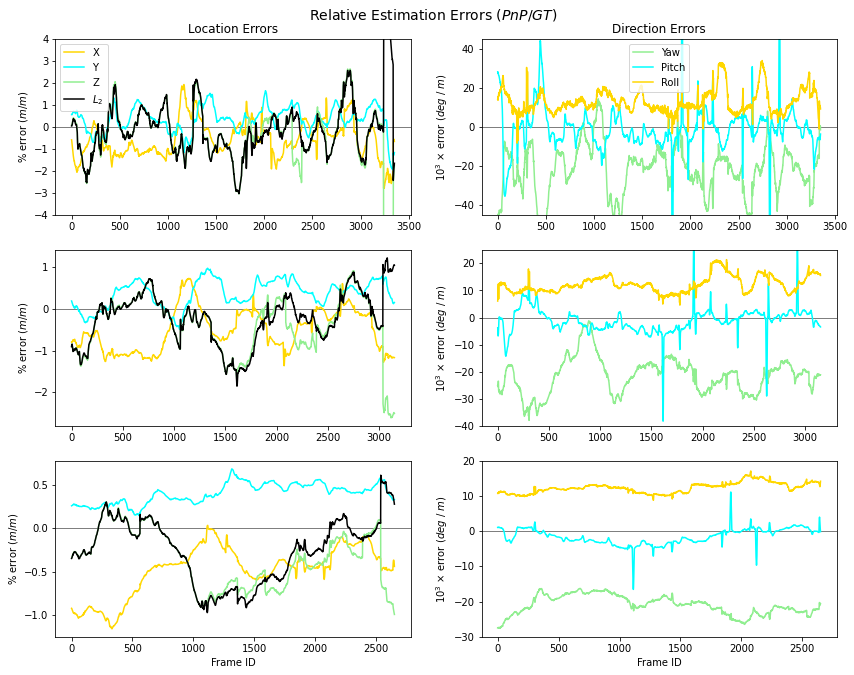

In [5]:
plt.clf()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 11))
fig.suptitle("Relative Estimation Errors ($PnP/GT$)", y=0.92, fontsize=14)
# fig.tight_layout()

gt_rel_dists = calculate_relative_distance(rel_gt_cameras)
window_sizes = [100, 300, 800]

# plot location errors
for i in range(3):
    ax = axes[i, 0]
    ax.axhline(0, c='k', linestyle="-", linewidth=0.5)
    w = window_sizes[i]
    ax.set_ylabel("% error " + "($m/m$)")
    for a in Axis:
        axis_errors = find_axis_errors(rel_pnp_cameras, rel_gt_cameras, a)
        cumulated_errors = running_sum(axis_errors, w)
        cumulated_distance = running_sum(gt_rel_dists, w)
        l = "$L_2$" if a == Axis.ALL else a.name
        ax.plot(cumulated_errors.index, 100 * cumulated_errors / cumulated_distance, label=l, c=COLORS[a.value])
    if i == 0:
        ax.legend()
        ax.set_ylim(bottom=-4, top=4)
        ax.set_title("Location Errors")
    if i == 2:
        ax.set_xlabel("Frame ID")

for i in range(3):
    ax = axes[i, 1]
    ax.axhline(0, c='k', linestyle="-", linewidth=0.5)
    w = window_sizes[i]
    ax.set_ylabel("$10^3$ $×$ error " + "($deg$ $/$ $m$)")
    for a in EA:
        angle_errors = find_angle_errors(rel_pnp_cameras, rel_gt_cameras, a)
        cumulated_errors = running_sum(angle_errors, w)
        cumulated_distance = running_sum(gt_rel_dists, w)
        ax.plot(cumulated_errors.index, 1e3 * cumulated_errors / cumulated_distance, label=a.name.capitalize(), c=COLORS[(2 - a.value) % 3])
    if i == 0:
        ax.legend()
        ax.set_ylim(bottom=-45, top=45)
        ax.set_title("Direction Errors")
    if i == 1:
        ax.set_ylim(bottom=-40, top=25)
    if i == 2:
        ax.set_xlabel("Frame ID")
        ax.set_ylim(bottom=-30, top=20)

plt.show()

##### Figure 13
relative errors for BA

<Figure size 432x288 with 0 Axes>

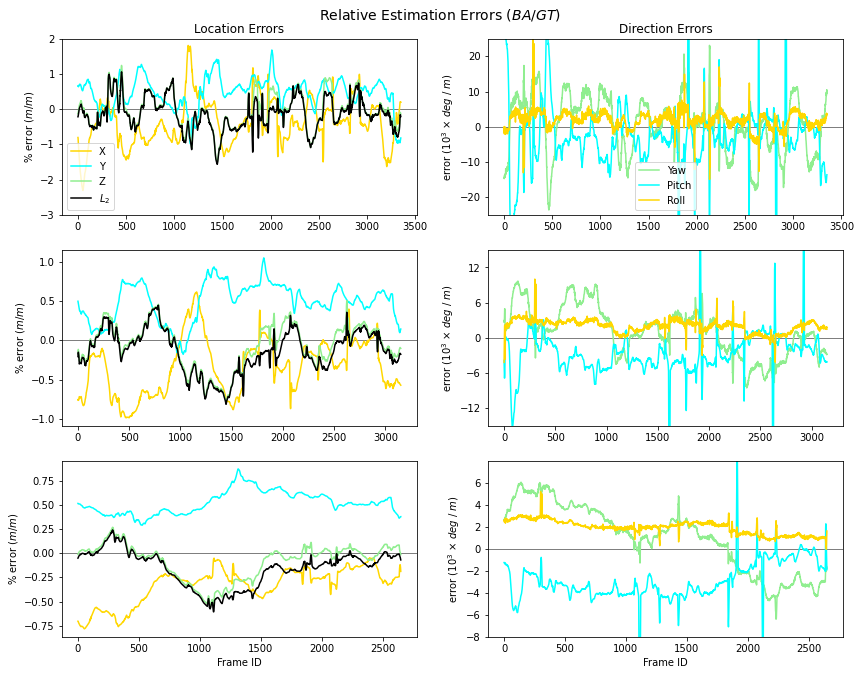

In [6]:
plt.clf()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 11))
fig.suptitle("Relative Estimation Errors ($BA/GT$)", y=0.92, fontsize=14)
# fig.tight_layout()

gt_rel_dists = calculate_relative_distance(rel_gt_cameras)
window_sizes = [100, 300, 800]

# plot location errors
for i in range(3):
    ax = axes[i, 0]
    ax.axhline(0, c='k', linestyle="-", linewidth=0.5)
    w = window_sizes[i]
    ax.set_ylabel("% error " + "($m/m$)")
    for a in Axis:
        axis_errors = find_axis_errors(rel_ba_cameras, rel_gt_cameras, a)
        cumulated_errors = running_sum(axis_errors, w)
        cumulated_distance = running_sum(gt_rel_dists, w)
        l = "$L_2$" if a == Axis.ALL else a.name
        ax.plot(cumulated_errors.index, 100 * cumulated_errors / cumulated_distance, label=l, c=COLORS[a.value])
    if i == 0:
        ax.legend()
        ax.set_ylim(bottom=-3, top=2)
        ax.set_title("Location Errors")
    if i == 2:
        ax.set_xlabel("Frame ID")

for i in range(3):
    ax = axes[i, 1]
    ax.axhline(0, c='k', linestyle="-", linewidth=0.5)
    w = window_sizes[i]
    ax.set_ylabel("error " + "($10^3$ $×$ $deg$ $/$ $m$)")
    for a in EA:
        angle_errors = find_angle_errors(rel_ba_cameras, rel_gt_cameras, a)
        cumulated_errors = running_sum(angle_errors, w)
        cumulated_distance = running_sum(gt_rel_dists, w)
        ax.plot(cumulated_errors.index, 1e3 * cumulated_errors / cumulated_distance, label=a.name.capitalize(), c=COLORS[(2 - a.value) % 3])
    if i == 0:
        ax.legend()
        ax.set_title("Direction Errors")
        ax.set_ylim(bottom=-25, top=25)
        ax.set_yticks([i for i in np.arange(-20, 26, 10)])
    if i == 1:
        ax.set_ylim(bottom=-15, top=15)
        ax.set_yticks([i for i in np.arange(-12, 13, 6)])
    if i == 2:
        ax.set_xlabel("Frame ID")
        ax.set_ylim(bottom=-8, top=8)
        ax.set_yticks([i for i in np.arange(-8, 7, 2)])

plt.show()

#### BUG :(

##### Figure 14
relative errors for PG

<Figure size 432x288 with 0 Axes>

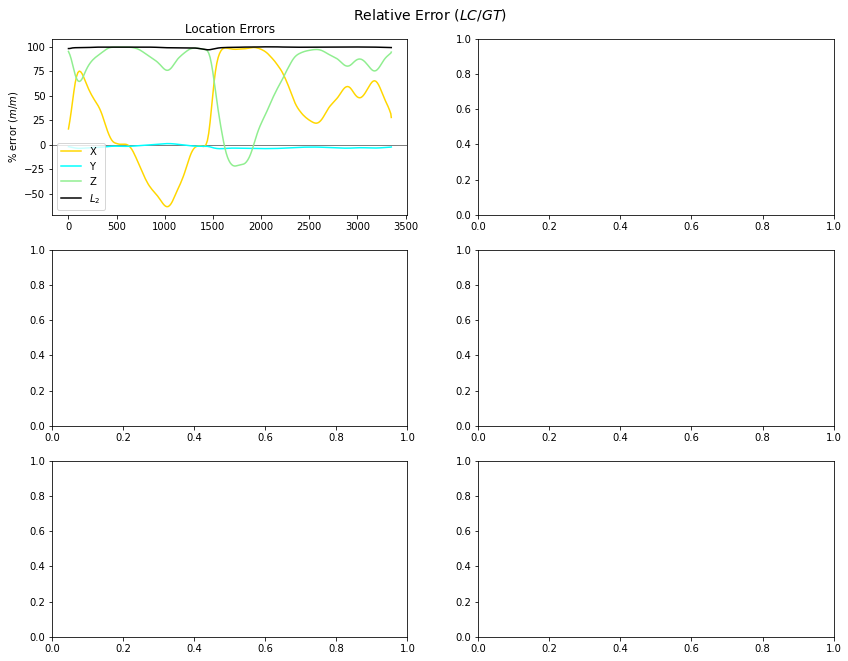

In [61]:
plt.clf()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 11))
fig.suptitle("Relative Error ($LC/GT$)", y=0.92, fontsize=14)
# fig.tight_layout()

rel_gt_cameras_for_pg = rel_gt_cameras[rel_gt_cameras.index.isin(rel_pg_cameras.index)]
abs_gt_cameras_for_pg = abs_gt_cameras[abs_gt_cameras.index.isin(abs_pg_cameras.index)]
gt_rel_dists = calculate_relative_distance(abs_gt_cameras_for_pg)
window_sizes = [100, 300, 800]

# plot location errors
for i in range(3):
    ax = axes[i, 0]
    ax.axhline(0, c='k', linestyle="-", linewidth=0.5)
    w = 1 + window_sizes[i] // (c.BUNDLE_SIZE - 1)
    ax.set_ylabel("% error " + "($m/m$)")
    for a in Axis:
        axis_errors = find_axis_errors(abs_pg_cameras, rel_gt_cameras_for_pg, a)
        cumulated_errors = running_sum(axis_errors, w)
        cumulated_distance = running_sum(gt_rel_dists, w)
        l = "$L_2$" if a == Axis.ALL else a.name
        ax.plot(cumulated_errors.index, 100 * cumulated_errors / cumulated_distance, label=l, c=COLORS[a.value])
    if i == 0:
        ax.legend()
        # ax.set_ylim(bottom=-3, top=2)
        ax.set_title("Location Errors")
    if i == 2:
        ax.set_xlabel("Frame ID")
    break

for i in range(3):
    break
    ax = axes[i, 1]
    ax.axhline(0, c='k', linestyle="-", linewidth=0.5)
    w = 1 + window_sizes[i] // (c.BUNDLE_SIZE - 1)
    ax.set_ylabel("% error " + "($deg/m$)")
    for a in EA:
        angle_errors = find_angle_errors(rel_pg_cameras, rel_gt_cameras_for_pg, a)
        cumulated_errors = running_sum(angle_errors, w)
        cumulated_distance = running_sum(gt_rel_dists, w)
        ax.plot(cumulated_errors.index, 100 * cumulated_errors / cumulated_distance, label=a.name.capitalize(), c=COLORS[(2 - a.value) % 3])
    if i == 0:
        ax.legend()
        ax.set_title("Direction Errors")
        # ax.set_ylim(bottom=-4, top=4)
    # if i == 1:
        # ax.set_ylim(bottom=-2, top=1.5)
    if i == 2:
        ax.set_xlabel("Frame ID")
        # ax.set_ylim(bottom=-0.75, top=0.75)

plt.show()